<a href="https://colab.research.google.com/github/JaiRamteke/Image_Generation_Diffusion_Model/blob/main/Image_Generation_Diffusion_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 01 | Test Accuracy: 0.5152 | Labeled Loss: 933.76 | Unlabeled Loss: 935.68
Epoch 02 | Test Accuracy: 0.5841 | Labeled Loss: 495.97 | Unlabeled Loss: 532.24
Epoch 03 | Test Accuracy: 0.6278 | Labeled Loss: 435.81 | Unlabeled Loss: 459.69
Epoch 04 | Test Accuracy: 0.6700 | Labeled Loss: 423.49 | Unlabeled Loss: 452.11
Epoch 05 | Test Accuracy: 0.6757 | Labeled Loss: 406.30 | Unlabeled Loss: 438.34
Epoch 06 | Test Accuracy: 0.6761 | Labeled Loss: 407.50 | Unlabeled Loss: 437.44
Epoch 07 | Test Accuracy: 0.6761 | Labeled Loss: 404.90 | Unlabeled Loss: 435.75
Epoch 08 | Test Accuracy: 0.6750 | Labeled Loss: 400.12 | Unlabeled Loss: 425.67
Epoch 09 | Test Accuracy: 0.6793 | Labeled Loss: 383.47 | Unlabeled Loss: 423.17
Epoch 10 | Test Accuracy: 0.6833 | Labeled Loss: 379.93 | Unlabeled Loss: 426.21
Epoch 11 | Test Accuracy: 0.6836 | Labeled Loss: 367.82 | Unlabeled Loss: 397.60
Epoch 12 | Test Accuracy: 0.6827 | Labeled Loss: 357.63 | Unlabeled Loss: 413.65
Epoch 13 | Test Accuracy: 0.

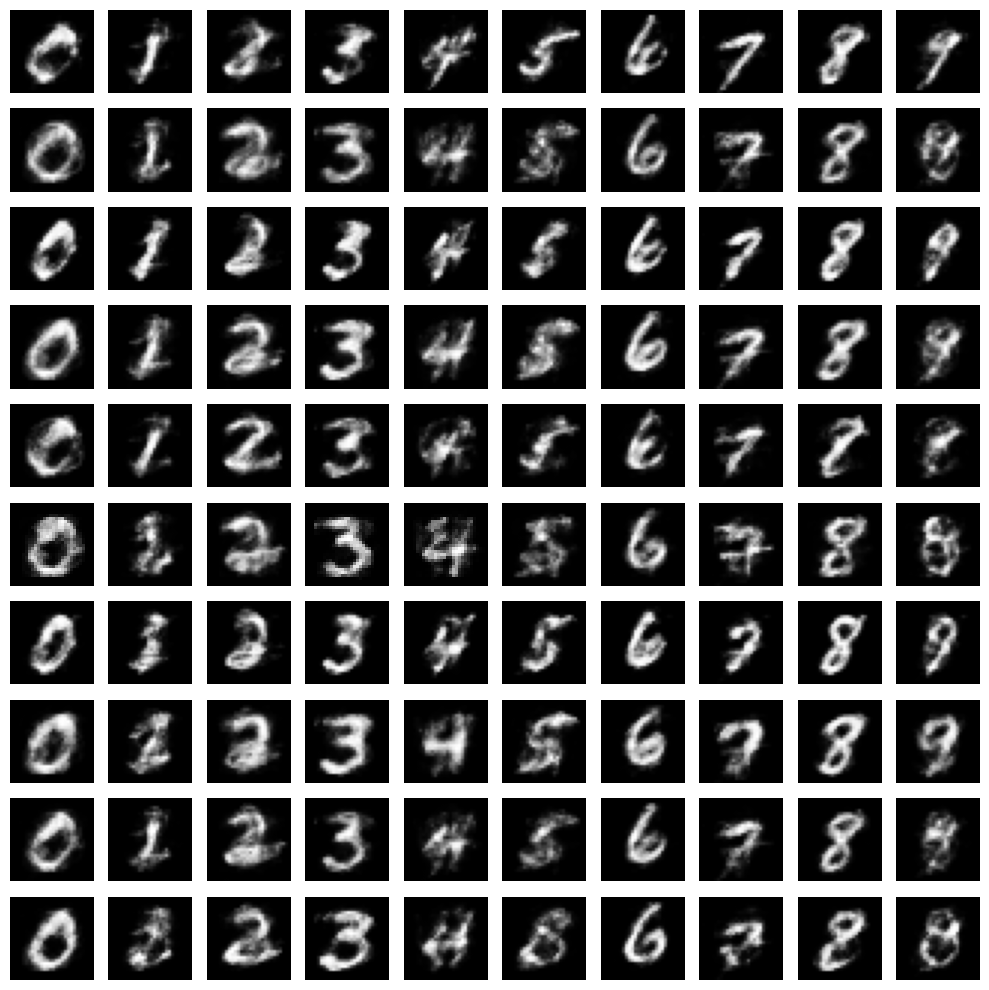

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

# ---------------------------------------------
# Step 1: Prepare Data
# ---------------------------------------------
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

def split_labeled_unlabeled(dataset, num_labels=100):
    targets = np.array(dataset.targets)
    labeled_idx = []
    for i in range(10):
        idx = np.where(targets == i)[0][:num_labels // 10]
        labeled_idx.extend(idx)
    unlabeled_idx = list(set(range(len(dataset))) - set(labeled_idx))
    return Subset(dataset, labeled_idx), Subset(dataset, unlabeled_idx)

labeled_dataset, unlabeled_dataset = split_labeled_unlabeled(train_dataset)
labeled_loader = DataLoader(labeled_dataset, batch_size=64, shuffle=True)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# ---------------------------------------------
# Step 2: Define Models
# ---------------------------------------------
def one_hot(y, num_classes=10):
    return F.one_hot(y, num_classes=num_classes).float()

class Encoder(nn.Module):
    def __init__(self, latent_dim=20, n_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(784 + n_classes, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

    def forward(self, x, y):
        xy = torch.cat([x, y], dim=1)
        h = F.relu(self.fc1(xy))
        return self.fc_mu(h), self.fc_logvar(h)

class Decoder(nn.Module):
    def __init__(self, latent_dim=20, n_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim + n_classes, 400)
        self.fc2 = nn.Linear(400, 784)

    def forward(self, z, y):
        zy = torch.cat([z, y], dim=1)
        h = F.relu(self.fc1(zy))
        return torch.sigmoid(self.fc2(h))

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(784, 10)

    def forward(self, x):
        return F.log_softmax(self.fc(x), dim=1)

def kl_divergence(mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)

def reconstruction_loss(x_recon, x_true):
    x_recon = torch.clamp(x_recon, 1e-6, 1 - 1e-6)
    x_true = torch.clamp(x_true, 0, 1)
    return F.binary_cross_entropy(x_recon, x_true, reduction='none').sum(dim=1)

class VAESSL(nn.Module):
    def __init__(self, latent_dim=20, n_classes=10):
        super().__init__()
        self.encoder = Encoder(latent_dim, n_classes)
        self.decoder = Decoder(latent_dim, n_classes)
        self.classifier = Classifier()
        self.n_classes = n_classes
        self.latent_dim = latent_dim

    def forward_labeled(self, x, y):
        mu, logvar = self.encoder(x, y)
        std = torch.exp(0.5 * logvar)
        z = mu + std * torch.randn_like(std)
        x_recon = self.decoder(z, y)
        return x_recon, mu, logvar

    def forward_unlabeled(self, x):
        log_probs = self.classifier(x)
        probs = log_probs.exp()
        total_loss = 0
        for i in range(self.n_classes):
            y_i = torch.eye(self.n_classes)[i].repeat(x.size(0), 1).to(device)
            mu, logvar = self.encoder(x, y_i)
            std = torch.exp(0.5 * logvar)
            z = mu + std * torch.randn_like(std)
            x_recon = self.decoder(z, y_i)

            recon = reconstruction_loss(x_recon, x)
            kl = kl_divergence(mu, logvar)
            elbo = recon + kl - log_probs[:, i]
            total_loss += probs[:, i] * elbo
        return total_loss.mean()

# ---------------------------------------------
# Step 3: Training Functions
# ---------------------------------------------
model = VAESSL().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)

def train_epoch(model, labeled_loader, unlabeled_loader, alpha=0.1, beta=1.0):
    model.train()
    total_labeled_loss = 0
    total_unlabeled_loss = 0

    for (x_l, y_l), (x_u, _) in zip(labeled_loader, unlabeled_loader):
        x_l = x_l.view(-1, 784).to(device)
        x_u = x_u.view(-1, 784).to(device)
        y_l = y_l.to(device)
        y_l_1h = one_hot(y_l).to(device)

        x_recon, mu, logvar = model.forward_labeled(x_l, y_l_1h)
        recon_loss = reconstruction_loss(x_recon, x_l)
        kl_loss = kl_divergence(mu, logvar)
        labeled_vae_loss = (recon_loss + kl_loss).mean()

        class_pred = model.classifier(x_l)
        class_loss = F.nll_loss(class_pred, y_l)

        unlabeled_loss = model.forward_unlabeled(x_u)

        loss = labeled_vae_loss + alpha * unlabeled_loss + beta * class_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_labeled_loss += (labeled_vae_loss + beta * class_loss).item()
        total_unlabeled_loss += unlabeled_loss.item()

    return total_labeled_loss, total_unlabeled_loss

def evaluate_classifier(model, loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.view(-1, 784).to(device)
            y = y.to(device)
            pred = model.classifier(x).argmax(1)
            correct += (pred == y).sum().item()
    return correct / len(loader.dataset)

# ---------------------------------------------
# Step 4: Training Loop
# ---------------------------------------------
for epoch in range(1, 51):
    l_loss, u_loss = train_epoch(model, labeled_loader, unlabeled_loader, alpha=0.1)
    acc = evaluate_classifier(model, test_loader)
    print(f"Epoch {epoch:02d} | Test Accuracy: {acc:.4f} | Labeled Loss: {l_loss:.2f} | Unlabeled Loss: {u_loss:.2f}")

# ---------------------------------------------
# Step 5: Image Generation
# ---------------------------------------------
def generate_images(model, num_samples=10):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, model.latent_dim).to(device)
        y = torch.eye(model.n_classes).to(device)
        imgs = model.decoder(z.unsqueeze(1).repeat(1, model.n_classes, 1).view(-1, model.latent_dim),
                             y.repeat(num_samples, 1))
        imgs = imgs.view(-1, 28, 28).cpu()

        fig, axes = plt.subplots(num_samples, model.n_classes, figsize=(model.n_classes, num_samples))
        for i in range(num_samples):
            for j in range(model.n_classes):
                axes[i, j].imshow(imgs[i * model.n_classes + j], cmap='gray')
                axes[i, j].axis('off')
        plt.tight_layout()
        plt.show()

generate_images(model)
